# Case Study 2

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




## 1.1
### Package required

In [2]:
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import metrics

## 1.2
### Clear output method

In [3]:
def clear_output():
  """
  clear output for both jupyter notebook and the console
  """
  import os
  os.system('cls' if os.name == 'nt' else 'clear')
  if is_in_notebook():
    from IPython.display import clear_output as clear
    clear()

def is_in_notebook():
  import sys
  return 'ipykernel' in sys.modules

## 1.3
### Load Data from CSV file

In [4]:
from sklearn.preprocessing import StandardScaler

# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
X_std = StandardScaler().fit_transform(X)
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]
data_df = pd.DataFrame(X)
data_df.columns = feature_names
target_array = np.array(y)
print(target_array)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 1.4
### Graph

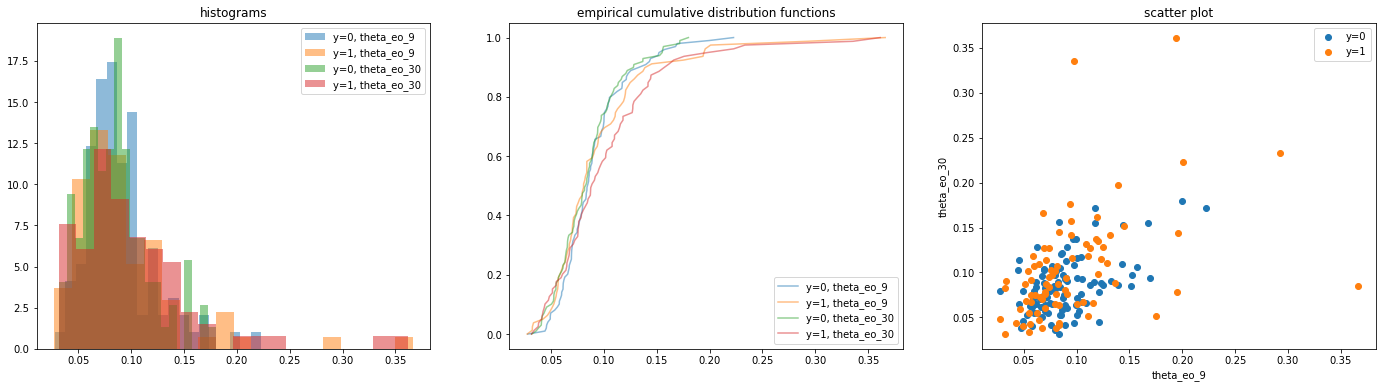

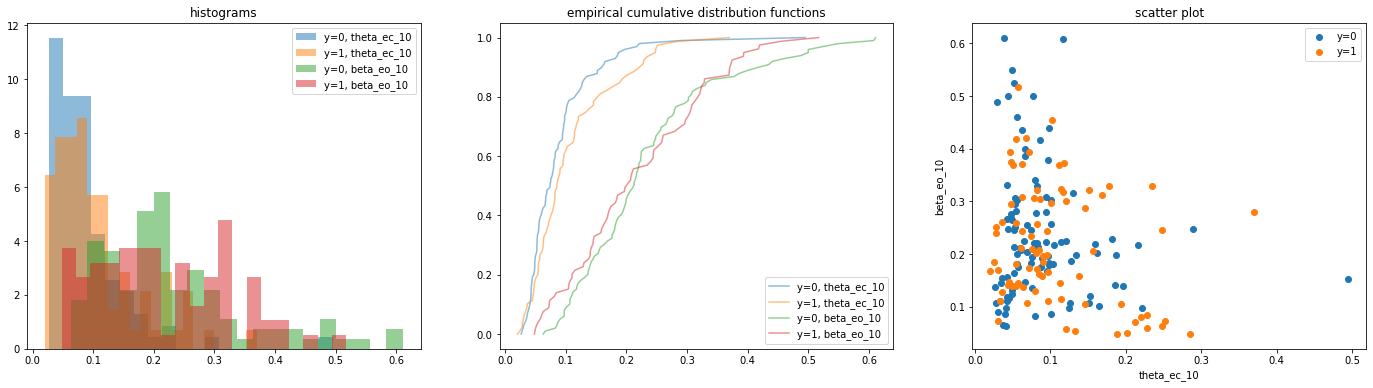

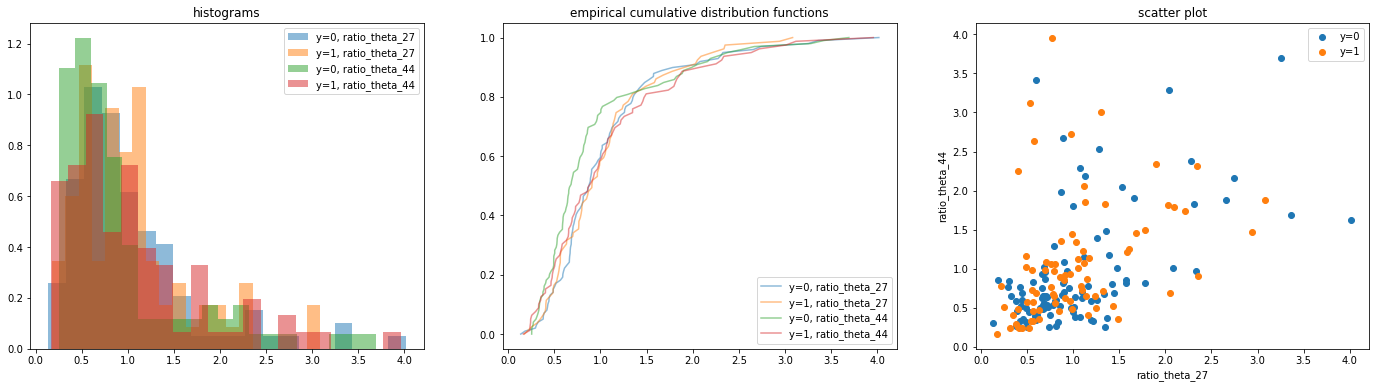

In [5]:
# plotting data in 2D with axes sampled 
# a) at random 
# b) from same electrode
# c) from same feature type
num_features = 9
num_electrodes = 48

# a) indices drawn at random
i0, i1 = np.random.randint(0, X.shape[1], size=2)

# b) same electrode, different feature (uncomment lines below)
f0, f1 = np.random.randint(0, num_features, size=2)
e = np.random.randint(0, num_electrodes)
i0_electrode, i1_electrode = f0*num_electrodes + e, f1*num_electrodes + e

# b) same feature, different electrode (uncomment lines below)
f = np.random.randint(0, num_features)
e0, e1 = np.random.randint(0, num_electrodes, size=2)
i0_feature, i1_feature = f*num_electrodes + e0, f*num_electrodes + e1


def plotting(i0,i1):
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    colors = ['blue', 'red']
    # select features i0, i1 and separate by class
    X00, X01 = X[y==0][:,i0], X[y==1][:,i0]
    X10, X11 = X[y==0][:,i1], X[y==1][:,i1]
    # plot cumulative distribution of feature i0 separate for each class
    axes[0].hist(X00, bins=20, label='y=0, '+ feature_names[i0], density=True, alpha=0.5)
    axes[0].hist(X01, bins=20, label='y=1, '+ feature_names[i0], density=True, alpha=0.5)
    axes[0].hist(X10, bins=20, label='y=0, '+ feature_names[i1], density=True, alpha=0.5)
    axes[0].hist(X11, bins=20, label='y=1, '+ feature_names[i1], density=True, alpha=0.5)
    axes[0].set_title('histograms')
    axes[0].legend()
    axes[1].plot(np.sort(X00), np.linspace(0,1,X00.shape[0]), label='y=0, '+ feature_names[i0], alpha=0.5)
    axes[1].plot(np.sort(X01), np.linspace(0,1,X01.shape[0]), label='y=1, '+ feature_names[i0], alpha=0.5)
    axes[1].plot(np.sort(X10), np.linspace(0,1,X10.shape[0]), label='y=0, '+ feature_names[i1], alpha=0.5)
    axes[1].plot(np.sort(X11), np.linspace(0,1,X11.shape[0]), label='y=1, '+ feature_names[i1], alpha=0.5)
    axes[1].set_title('empirical cumulative distribution functions')
    axes[1].legend()
    axes[2].scatter(X00, X10, label='y=0')
    axes[2].scatter(X01, X11, label='y=1')
    axes[2].set_xlabel(feature_names[i0])
    axes[2].set_ylabel(feature_names[i1])
    axes[2].set_title('scatter plot')
    axes[2].legend()
    
plotting(i0,i1)
plotting(i0_electrode,i1_electrode)
plotting(i0_feature,i1_feature)


## 1.5
### Split data

In [6]:
#split data to test and train sets
from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_std, y, test_size = 0.30,  random_state = 101) 

In [8]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#random forest tree
start = time.process_time()
trainedforest = RandomForestClassifier(n_estimators=800).fit(X_Train,Y_Train)
print(time.process_time() - start)
predictionforest = trainedforest.predict(X_Test)
print(confusion_matrix(Y_Test,predictionforest))
print(classification_report(Y_Test,predictionforest))

scores = cross_val_score(trainedforest, X_std, y, cv=13, n_jobs = 1)
print('CV accuracy scores: %s' %scores)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))


0.703125
[[26  5]
 [ 1 22]]
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90        31
         1.0       0.81      0.96      0.88        23

    accuracy                           0.89        54
   macro avg       0.89      0.90      0.89        54
weighted avg       0.90      0.89      0.89        54

CV accuracy scores: [0.71428571 1.         0.92857143 0.85714286 0.85714286 0.92857143
 0.78571429 0.78571429 0.85714286 0.78571429 0.92857143 1.
 0.84615385]
CV accuracy: 0.867 +/- 0.083


<AxesSubplot:>

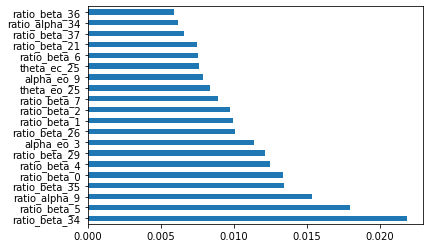

In [9]:

feat_importances = pd.Series(trainedforest.feature_importances_, index= data_df.columns)
feat_importances.nlargest(20).plot(kind='barh')

## 1.6
### Test differnet models to choose the best

In [10]:

X_Reduced = data_df[['ratio_beta_34','ratio_beta_4', 'ratio_beta_5','ratio_beta_35','ratio_beta_2','ratio_beta_1']]
X_Train2, X_Test2, Y_Train2, Y_Test2 = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)
start = time.process_time()
trainedforest = RandomForestClassifier(n_estimators=800).fit(X_Train2,Y_Train2)
print(time.process_time() - start)
predictionforest = trainedforest.predict(X_Test2)
print(confusion_matrix(Y_Test2,predictionforest))
print(classification_report(Y_Test2,predictionforest))
scores = cross_val_score(trainedforest, X_std, y, cv=10, n_jobs = 1)
print('CV accuracy scores: %s' %scores)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))


0.484375
[[23  8]
 [ 5 18]]
              precision    recall  f1-score   support

         0.0       0.82      0.74      0.78        31
         1.0       0.69      0.78      0.73        23

    accuracy                           0.76        54
   macro avg       0.76      0.76      0.76        54
weighted avg       0.77      0.76      0.76        54

CV accuracy scores: [0.83333333 0.94444444 0.88888889 0.94444444 0.88888889 0.77777778
 0.77777778 0.94444444 1.         0.88888889]
CV accuracy: 0.889 +/- 0.070


In [11]:
from sklearn import tree
#decision tree
start = time.process_time()
trainedtree = tree.DecisionTreeClassifier().fit(X_Train, Y_Train)
print(time.process_time() - start)
predictionstree = trainedtree.predict(X_Test)
print(confusion_matrix(Y_Test,predictionstree))
print(classification_report(Y_Test,predictionstree))

scores = cross_val_score(trainedtree, X_std, y, cv=10, n_jobs = 1)
print('CV accuracy scores: %s' %scores)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

0.0
[[21 10]
 [ 5 18]]
              precision    recall  f1-score   support

         0.0       0.81      0.68      0.74        31
         1.0       0.64      0.78      0.71        23

    accuracy                           0.72        54
   macro avg       0.73      0.73      0.72        54
weighted avg       0.74      0.72      0.72        54

CV accuracy scores: [0.83333333 0.83333333 0.61111111 0.77777778 0.66666667 0.72222222
 0.77777778 0.72222222 0.77777778 0.72222222]
CV accuracy: 0.744 +/- 0.067


In [12]:
from sklearn.model_selection import cross_val_score
start = time.process_time()
lr = LogisticRegression()
lr.fit(X_Train, Y_Train)

print(time.process_time() - start)
predictionLR = lr.predict(X_Test)
print(confusion_matrix(Y_Test,predictionLR))
print(classification_report(Y_Test,predictionLR))

print("Accuracy:",metrics.accuracy_score(Y_Test, predictionLR))
scores = cross_val_score(lr, X_std, y, cv=10, n_jobs = 1)
print('CV accuracy scores: %s' %scores)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))

0.015625
[[30  1]
 [ 5 18]]
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91        31
         1.0       0.95      0.78      0.86        23

    accuracy                           0.89        54
   macro avg       0.90      0.88      0.88        54
weighted avg       0.90      0.89      0.89        54

Accuracy: 0.8888888888888888
CV accuracy scores: [0.88888889 0.94444444 0.94444444 0.94444444 0.94444444 0.94444444
 0.88888889 0.94444444 1.         1.        ]
CV accuracy: 0.944 +/- 0.035


In [13]:
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score

start = time.process_time()
clf = svm.SVC()
clf.fit(X_Train, Y_Train)
print(time.process_time() - start)

y_pred = clf.predict(X_Test)
print(confusion_matrix(Y_Test,y_pred))
print(classification_report(Y_Test,y_pred))

print("Accuracy:",metrics.accuracy_score(Y_Test, y_pred))

scores = cross_val_score(clf, X_std, y, cv=10, n_jobs = 1)
print('CV accuracy scores: %s' %scores)
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))


0.0
[[29  2]
 [ 5 18]]
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89        31
         1.0       0.90      0.78      0.84        23

    accuracy                           0.87        54
   macro avg       0.88      0.86      0.86        54
weighted avg       0.87      0.87      0.87        54

Accuracy: 0.8703703703703703
CV accuracy scores: [0.77777778 0.94444444 0.88888889 0.94444444 0.94444444 0.83333333
 0.77777778 0.83333333 1.         0.94444444]
CV accuracy: 0.889 +/- 0.075


## 2.1
### Feature selection
#### Filter method

In [14]:
def pearson_correlation(X,y,number_of_k):
    np.random.seed(0)
    size = 300
    x = np.random.normal(0, 1, size)
    print("Lower noise：", pearsonr(x, x + np.random.normal(0, 1, size)))
    print("Higher noise：", pearsonr(x, x + np.random.normal(0, 10, size)))
    data = SelectKBest(lambda X, Y: tuple(map(tuple,np.array(list(map(lambda x:pearsonr(x, Y), X.T))).T)), k=number_of_k).fit_transform(X, y)
    data = pd.DataFrame(data)
    List = []
    for j in data:
        for i in range(432):
            name = feature_names[i]
            if (data_df[name].values == data[j].values).all():
                List.append(feature_names[i])
    print(List)
    data.columns = List
    return data
pearson_correlation(X,y,10)


Lower noise： (0.7182483686213833, 7.324017313001002e-49)
Higher noise： (0.057964292079338064, 0.3170099388532581)
['ratio_beta_0', 'ratio_beta_2', 'ratio_beta_4', 'ratio_beta_7', 'ratio_beta_21', 'ratio_beta_29', 'ratio_beta_34', 'ratio_beta_35', 'ratio_beta_37', 'ratio_beta_47']


,ratio_beta_0,ratio_beta_2,ratio_beta_4,ratio_beta_7,ratio_beta_21,ratio_beta_29,ratio_beta_34,ratio_beta_35,ratio_beta_37,ratio_beta_47
0,1.23500,1.22680,1.26750,1.02310,1.31220,1.19120,0.63706,0.86707,0.93515,1.59830
1,1.04240,1.05680,1.22550,1.10720,0.94879,0.98388,0.90240,1.02660,0.97857,1.16220
2,0.70472,0.74024,0.65965,0.45349,0.68753,0.82225,0.58833,0.76459,0.61297,0.87119
3,0.42816,0.41978,0.39411,0.49409,0.66735,0.43101,0.32415,0.30058,0.23383,0.43780
4,0.72726,0.89302,0.79444,0.67252,0.68665,0.72945,0.56497,0.76767,0.83275,0.66131
...,...,...,...,...,...,...,...,...,...,...
175,0.97047,1.00130,1.17270,1.59610,2.30840,1.22900,1.54750,0.77709,1.32380,1.42300
176,0.94369,0.84917,0.94491,0.87586,0.79784,0.95665,0.76839,1.01750,1.20300,1.26510
177,0.84642,0.83630,0.83018,0.69976,0.76089,0.76630,0.58644,0.58794,0.84352,0.85338
178,0.76431,0.71892,1.34150,0.81159,0.62936,1.11400,0.80789,0.88612,1.36080,1.57850


In [15]:
data_with_variance = VarianceThreshold(threshold=3).fit_transform(X,y)
print(data_with_variance.shape)

(180, 36)


In [16]:
def Chi_Square(X,y,number_of_k):
    data = SelectKBest(chi2, k=number_of_k).fit_transform(X, y)
    data = pd.DataFrame(data)
    List = []
    for j in data:
        for i in range(432):
            name = feature_names[i]
            if (data_df[name].values == data[j].values).all():
                List.append(feature_names[i])
    print(List)
    data.columns = List
    return pd.DataFrame(data)
Chi_Square(X,y,20)

['ratio_alpha_0', 'ratio_alpha_3', 'ratio_alpha_5', 'ratio_alpha_6', 'ratio_alpha_17', 'ratio_alpha_21', 'ratio_alpha_23', 'ratio_alpha_25', 'ratio_alpha_26', 'ratio_alpha_30', 'ratio_alpha_33', 'ratio_alpha_34', 'ratio_alpha_35', 'ratio_alpha_36', 'ratio_alpha_37', 'ratio_alpha_41', 'ratio_alpha_47', 'ratio_beta_1', 'ratio_beta_5', 'ratio_beta_37']


,ratio_alpha_0,ratio_alpha_3,ratio_alpha_5,ratio_alpha_6,ratio_alpha_17,ratio_alpha_21,ratio_alpha_23,ratio_alpha_25,ratio_alpha_26,ratio_alpha_30,ratio_alpha_33,ratio_alpha_34,ratio_alpha_35,ratio_alpha_36,ratio_alpha_37,ratio_alpha_41,ratio_alpha_47,ratio_beta_1,ratio_beta_5,ratio_beta_37
0,1.45370,1.69490,1.02450,1.13870,1.91180,1.44250,1.85860,2.40090,3.18010,1.48800,2.23420,2.75800,2.58600,1.94120,1.89280,2.16820,1.62070,1.21480,1.09130,0.93515
1,4.19340,6.14820,4.15950,3.22590,6.87180,5.28670,3.38270,4.53320,3.42730,5.76500,5.82750,5.27070,3.76240,4.42820,6.45560,7.13380,6.98290,0.99510,1.15470,0.97857
2,1.07270,0.70045,1.46390,1.59100,1.71060,2.00330,1.38800,2.02010,1.20940,1.61300,1.61590,1.04840,0.79325,0.86341,1.04990,1.28190,0.98162,0.71207,0.54323,0.61297
3,10.19500,5.84530,4.90340,4.91930,2.50710,3.69960,2.59590,3.11540,3.54040,3.87060,3.53240,4.32480,4.73620,5.62670,6.52150,5.37310,4.94840,0.42361,0.41132,0.23383
4,1.43730,0.63543,0.95396,0.80977,0.72041,1.20290,0.72554,0.71139,0.66747,0.59036,0.92538,0.83216,0.87790,0.79245,0.85155,1.06290,0.77983,0.87960,0.66454,0.83275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.12540,1.81590,1.22170,0.99353,0.45449,0.75050,0.97855,0.33663,0.55630,0.89994,0.44971,0.55189,0.72181,1.20500,1.19500,0.45075,1.06060,0.99976,1.33080,1.32380
176,1.03380,0.63895,1.30950,1.58650,0.87236,1.25810,1.93190,1.87930,1.41080,0.92505,1.52130,1.33960,1.40680,1.20680,0.62798,1.60040,0.64112,0.81221,0.80406,1.20300
177,0.30071,0.36121,0.26936,0.24673,0.57351,0.50677,0.68575,0.28535,0.40083,0.54422,0.32517,0.39002,0.44586,0.44786,0.44607,0.39912,0.47200,0.84743,0.82331,0.84352
178,1.57110,1.20380,2.19770,2.31680,1.35480,1.25620,0.77634,1.09340,0.94351,2.41040,1.41550,1.26690,1.26960,1.49530,1.77720,1.54740,1.32690,0.79087,0.95940,1.36080


In [17]:
from sklearn.feature_selection import mutual_info_classif
def Mutual_Information(X,y,number_of_k):
    data = SelectKBest(mutual_info_classif, k=number_of_k).fit_transform(X, y)
    data = pd.DataFrame(data)
    List = []
    for j in data:
        for i in range(432):
            name = feature_names[i]
            if (data_df[name].values == data[j].values).all():
                List.append(feature_names[i])
    print(List)
    data.columns = List
    return pd.DataFrame(data)
Mutual_Information(X,y,20)

['alpha_ec_25', 'alpha_ec_37', 'beta_ec_5', 'beta_ec_28', 'beta_ec_46', 'theta_ec_32', 'alpha_eo_9', 'alpha_eo_24', 'beta_eo_17', 'beta_eo_18', 'beta_eo_29', 'ratio_alpha_2', 'ratio_alpha_35', 'ratio_beta_0', 'ratio_beta_5', 'ratio_beta_6', 'ratio_beta_8', 'ratio_beta_21', 'ratio_beta_35', 'ratio_beta_37']


,alpha_ec_25,alpha_ec_37,beta_ec_5,beta_ec_28,beta_ec_46,theta_ec_32,alpha_eo_9,alpha_eo_24,beta_eo_17,beta_eo_18,beta_eo_29,ratio_alpha_2,ratio_alpha_35,ratio_beta_0,ratio_beta_5,ratio_beta_6,ratio_beta_8,ratio_beta_21,ratio_beta_35,ratio_beta_37
0,0.141700,0.179130,0.312560,0.346180,0.252740,0.055208,0.071669,0.079085,0.249790,0.317160,0.252180,1.77510,2.58600,1.23500,1.09130,1.00150,1.16080,1.31220,0.86707,0.93515
1,0.418040,0.462410,0.077756,0.107920,0.105070,0.103670,0.088216,0.072778,0.152530,0.138890,0.110120,3.08200,3.76240,1.04240,1.15470,1.06150,1.03750,0.94879,1.02660,0.97857
2,0.461550,0.389170,0.170970,0.338680,0.142380,0.058830,0.314870,0.331250,0.381740,0.527330,0.361670,1.27330,0.79325,0.70472,0.54323,0.45100,0.56800,0.68753,0.76459,0.61297
3,0.555470,0.805060,0.070115,0.090197,0.068598,0.041778,0.099424,0.153730,0.221050,0.227940,0.198190,7.28300,4.73620,0.42816,0.41132,0.44999,0.51075,0.66735,0.30058,0.23383
4,0.162070,0.181650,0.084080,0.131890,0.052449,0.227290,0.112600,0.216290,0.108100,0.157440,0.182990,1.15490,0.87790,0.72726,0.66454,0.62695,0.74782,0.68665,0.76767,0.83275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.056397,0.066051,0.059158,0.050238,0.090077,0.283620,0.126510,0.071574,0.065861,0.044232,0.048704,0.76572,0.72181,0.97047,1.33080,1.42740,1.45930,2.30840,0.77709,1.32380
176,0.583010,0.423540,0.181890,0.181490,0.176140,0.052334,0.229140,0.159310,0.193840,0.204210,0.168910,1.06040,1.40680,0.94369,0.80406,0.80449,0.88112,0.79784,1.01750,1.20300
177,0.180270,0.225560,0.089045,0.098575,0.097484,0.082611,0.650210,0.510260,0.205290,0.191100,0.163150,0.30018,0.44586,0.84642,0.82331,0.75637,0.74815,0.76089,0.58794,0.84352
178,0.446000,0.965860,0.334290,0.214450,0.194510,0.040699,0.679350,0.671480,0.297380,0.367210,0.203680,1.48810,1.26960,0.76431,0.95940,0.81265,1.02390,0.62936,0.88612,1.36080


In [18]:
from sklearn.feature_selection import f_classif
def ANOVA(X,y,number_of_k):
    data = SelectKBest(f_classif, k=number_of_k).fit_transform(X, y)
    data = pd.DataFrame(data)
    List = []
    for j in data:
        for i in range(432):
            name = feature_names[i]
            if (data_df[name].values == data[j].values).all():
                List.append(feature_names[i])
    print(List)
    data.columns = List
    return pd.DataFrame(data)
ANOVA(X,y,20)

['alpha_ec_17', 'alpha_ec_23', 'alpha_ec_25', 'alpha_ec_31', 'ratio_beta_0', 'ratio_beta_2', 'ratio_beta_4', 'ratio_beta_6', 'ratio_beta_7', 'ratio_beta_13', 'ratio_beta_21', 'ratio_beta_26', 'ratio_beta_29', 'ratio_beta_30', 'ratio_beta_34', 'ratio_beta_35', 'ratio_beta_36', 'ratio_beta_37', 'ratio_beta_38', 'ratio_beta_47']


,alpha_ec_17,alpha_ec_23,alpha_ec_25,alpha_ec_31,ratio_beta_0,ratio_beta_2,ratio_beta_4,ratio_beta_6,ratio_beta_7,ratio_beta_13,ratio_beta_21,ratio_beta_26,ratio_beta_29,ratio_beta_30,ratio_beta_34,ratio_beta_35,ratio_beta_36,ratio_beta_37,ratio_beta_38,ratio_beta_47
0,0.10175,0.12972,0.141700,0.132030,1.23500,1.22680,1.26750,1.00150,1.02310,1.23210,1.31220,0.87884,1.19120,0.93359,0.63706,0.86707,1.19650,0.93515,0.67875,1.59830
1,0.33360,0.27856,0.418040,0.388990,1.04240,1.05680,1.22550,1.06150,1.10720,0.90021,0.94879,0.88489,0.98388,1.20350,0.90240,1.02660,0.91724,0.97857,0.94463,1.16220
2,0.41165,0.39364,0.461550,0.494250,0.70472,0.74024,0.65965,0.45100,0.45349,0.45662,0.68753,0.67878,0.82225,0.85246,0.58833,0.76459,0.78642,0.61297,0.47783,0.87119
3,0.42615,0.35979,0.555470,0.288550,0.42816,0.41978,0.39411,0.44999,0.49409,0.56533,0.66735,0.49578,0.43101,0.32320,0.32415,0.30058,0.31453,0.23383,0.22539,0.43780
4,0.13692,0.20920,0.162070,0.219060,0.72726,0.89302,0.79444,0.62695,0.67252,0.48123,0.68665,0.70739,0.72945,0.65966,0.56497,0.76767,0.73220,0.83275,0.59676,0.66131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.06100,0.08423,0.056397,0.055541,0.97047,1.00130,1.17270,1.42740,1.59610,1.87020,2.30840,1.50440,1.22900,1.64880,1.54750,0.77709,0.69900,1.32380,1.82090,1.42300
176,0.35489,0.42728,0.583010,0.552630,0.94369,0.84917,0.94491,0.80449,0.87586,0.83905,0.79784,0.82372,0.95665,0.89290,0.76839,1.01750,0.98684,1.20300,0.79324,1.26510
177,0.23536,0.39587,0.180270,0.190110,0.84642,0.83630,0.83018,0.75637,0.69976,0.63518,0.76089,0.61825,0.76630,0.85823,0.58644,0.58794,0.67413,0.84352,0.96451,0.85338
178,0.39758,0.48125,0.446000,0.516480,0.76431,0.71892,1.34150,0.81265,0.81159,0.68045,0.62936,1.17740,1.11400,1.33870,0.80789,0.88612,1.01410,1.36080,1.11220,1.57850


## 2.2
### Feature selection
#### wrapper method

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector

def SFS_forward(X,y,num_of_k):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=num_of_k,direction='forward')
    sfs = sfs.fit(X, y)
    data = pd.DataFrame(sfs.transform(X))
    List = []
    for j in data:
        for i in range(432):
            name = feature_names[i]
            if (data_df[name].values == data[j].values).all():
                List.append(feature_names[i])
    print(List)
    data.columns = List
    return data
SFS_forward(X,y,20)

['alpha_ec_21', 'alpha_ec_22', 'alpha_ec_23', 'alpha_ec_27', 'alpha_ec_28', 'alpha_ec_29', 'alpha_ec_44', 'alpha_ec_45', 'beta_ec_2', 'beta_ec_14', 'beta_ec_17', 'beta_ec_23', 'beta_ec_27', 'beta_ec_34', 'beta_ec_35', 'theta_ec_17', 'beta_eo_26', 'ratio_beta_34', 'ratio_beta_44', 'ratio_theta_40']


,alpha_ec_21,alpha_ec_22,alpha_ec_23,alpha_ec_27,alpha_ec_28,alpha_ec_29,alpha_ec_44,alpha_ec_45,beta_ec_2,beta_ec_14,beta_ec_17,beta_ec_23,beta_ec_27,beta_ec_34,beta_ec_35,theta_ec_17,beta_eo_26,ratio_beta_34,ratio_beta_44,ratio_theta_40
0,0.087974,0.090929,0.12972,0.12293,0.083008,0.105590,0.104750,0.098602,0.309200,0.387410,0.354950,0.31422,0.304990,0.232860,0.239610,0.081393,0.360700,0.63706,0.68027,0.58709
1,0.328170,0.337920,0.27856,0.23100,0.177320,0.320530,0.408980,0.391920,0.091370,0.108470,0.140940,0.16866,0.109220,0.107960,0.110960,0.069344,0.145940,0.90240,1.51740,0.43164
2,0.402090,0.474890,0.39364,0.31165,0.209350,0.401770,0.487600,0.437940,0.228960,0.265280,0.289430,0.35549,0.356920,0.226200,0.243870,0.050657,0.471370,0.58833,0.49853,1.09310
3,0.536590,0.492700,0.35979,0.52217,0.567330,0.596350,0.687010,0.549120,0.076116,0.103990,0.117760,0.14600,0.086096,0.072740,0.068372,0.048335,0.190050,0.32415,0.43999,0.43196
4,0.253540,0.240370,0.20920,0.27876,0.285130,0.257590,0.168550,0.150160,0.102790,0.101970,0.097030,0.11762,0.139310,0.088154,0.119030,0.158290,0.178710,0.56497,0.38013,1.24420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.063995,0.059637,0.08423,0.16160,0.150080,0.079835,0.048168,0.048618,0.055178,0.076992,0.092239,0.10799,0.048026,0.061741,0.042432,0.191430,0.037058,1.54750,0.97656,0.95190
176,0.635400,0.581750,0.42728,0.56291,0.512780,0.518970,0.639470,0.468820,0.231700,0.219120,0.176850,0.19690,0.177410,0.121590,0.178860,0.083197,0.187880,0.76839,0.59737,0.82459
177,0.237040,0.338600,0.39587,0.19288,0.173610,0.210600,0.233060,0.209260,0.079214,0.074325,0.116220,0.14243,0.093792,0.074731,0.070403,0.134180,0.163070,0.58644,0.63495,0.64390
178,0.582090,0.544460,0.48125,0.74031,0.752190,0.799040,0.626020,0.630320,0.131950,0.248670,0.328920,0.33610,0.232440,0.152770,0.156160,0.057972,0.218160,0.80789,0.40892,0.59572


In [ ]:
def SFS_backward(X,y,num_of_k):
    sfs = SequentialFeatureSelector(lr, n_features_to_select=num_of_k,direction='backward')
    sfs = sfs.fit(X, y)
    return sfs.transform(X)

In [20]:
from sklearn.svm import SVR
# Wrapping Method
# RFE without
def RFE_without(X, y,num_of_k):
    RFE_estimator = SVR(kernel="linear")
    RFE_selector = RFE(RFE_estimator, n_features_to_select=num_of_k, step=1)
    RFE_selector = RFE_selector.fit(X, y)
    result = RFE_selector.support_
    Temp = []
    for i in range (432):
        if result[i] == True:
            Temp.append(i)
    List = []
    for i in Temp:
        List.append(data_df.columns[i])
    print(List)
    X_Reduced = data_df[List]
    return X_Reduced
RFE_without(X, y,20)

['alpha_ec_5', 'alpha_ec_33', 'alpha_ec_45', 'beta_ec_11', 'beta_ec_12', 'theta_ec_25', 'alpha_eo_1', 'alpha_eo_3', 'alpha_eo_7', 'alpha_eo_9', 'alpha_eo_24', 'alpha_eo_34', 'beta_eo_26', 'beta_eo_27', 'theta_eo_6', 'theta_eo_8', 'theta_eo_19', 'theta_eo_26', 'ratio_beta_15', 'ratio_beta_24']


,alpha_ec_5,alpha_ec_33,alpha_ec_45,beta_ec_11,beta_ec_12,theta_ec_25,alpha_eo_1,alpha_eo_3,alpha_eo_7,alpha_eo_9,alpha_eo_24,alpha_eo_34,beta_eo_26,beta_eo_27,theta_eo_6,theta_eo_8,theta_eo_19,theta_eo_26,ratio_beta_15,ratio_beta_24
0,0.106900,0.188990,0.098602,0.313350,0.296830,0.070699,0.077948,0.066810,0.074576,0.071669,0.079085,0.081669,0.360700,0.318200,0.099248,0.064291,0.113800,0.046980,1.09530,1.05820
1,0.285000,0.494140,0.391920,0.084261,0.081574,0.086228,0.070942,0.061821,0.079901,0.088216,0.072778,0.095320,0.145940,0.129820,0.267140,0.174940,0.161850,0.125350,0.96143,1.16730
2,0.441990,0.482930,0.437940,0.193740,0.167010,0.051957,0.327380,0.367930,0.211050,0.314870,0.331250,0.439550,0.471370,0.415730,0.115640,0.106990,0.051873,0.077165,0.92548,0.90772
3,0.727250,0.661110,0.549120,0.081871,0.084160,0.032638,0.085582,0.102920,0.142740,0.099424,0.153730,0.168640,0.190050,0.159570,0.185420,0.089333,0.121340,0.086873,0.51508,0.67086
4,0.141540,0.182290,0.150160,0.083387,0.080252,0.212580,0.122620,0.247520,0.150680,0.112600,0.216290,0.248520,0.178710,0.178630,0.129200,0.105320,0.103620,0.079765,0.66181,0.63897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.063498,0.068566,0.048618,0.069538,0.068027,0.270400,0.085272,0.046107,0.080831,0.126510,0.071574,0.190310,0.037058,0.046079,0.135740,0.142390,0.134320,0.120530,1.66260,1.36660
176,0.379750,0.723120,0.468820,0.162800,0.174070,0.049408,0.323500,0.433900,0.255320,0.229140,0.159310,0.564040,0.187880,0.156260,0.107070,0.119760,0.079244,0.090879,1.10770,1.30110
177,0.132490,0.212050,0.209260,0.120080,0.100660,0.107150,0.543340,0.495490,0.553160,0.650210,0.510260,0.679700,0.163070,0.134610,0.133760,0.114490,0.117150,0.068481,0.58585,0.84221
178,0.655290,0.686120,0.630320,0.387320,0.308720,0.047236,0.614110,0.603600,0.272590,0.679350,0.671480,0.617850,0.218160,0.229290,0.027408,0.027575,0.055943,0.029288,1.30640,1.17710


In [21]:
from sklearn.feature_selection import RFECV
def RFE_with_CV(X, y):
    RFE_with_CV_estimator = SVR(kernel="linear")
    RFE_with_CV_selector = RFECV(RFE_with_CV_estimator, step=1, cv=5)
    RFE_with_CV_selector = RFE_with_CV_selector.fit(X, y)
    result = RFE_with_CV_selector.support_
    Temp = []
    for i in range (432):
        if result[i] == True:
            Temp.append(i)
    List = []
    for i in Temp:
        List.append(data_df.columns[i])
    print(List)
    X_Reduced = data_df[List]
    return X_Reduced,List

RFE_with_CV(X, y)

['alpha_ec_5', 'alpha_ec_33', 'alpha_ec_45', 'beta_ec_11', 'beta_ec_12', 'theta_ec_25', 'theta_ec_46', 'alpha_eo_1', 'alpha_eo_3', 'alpha_eo_7', 'alpha_eo_9', 'alpha_eo_24', 'alpha_eo_34', 'beta_eo_26', 'beta_eo_27', 'theta_eo_6', 'theta_eo_8', 'theta_eo_19', 'theta_eo_26', 'theta_eo_27', 'ratio_beta_15', 'ratio_beta_24']


(     alpha_ec_5  alpha_ec_33  alpha_ec_45  beta_ec_11  beta_ec_12  \
 0      0.106900     0.188990     0.098602    0.313350    0.296830   
 1      0.285000     0.494140     0.391920    0.084261    0.081574   
 2      0.441990     0.482930     0.437940    0.193740    0.167010   
 3      0.727250     0.661110     0.549120    0.081871    0.084160   
 4      0.141540     0.182290     0.150160    0.083387    0.080252   
 ..          ...          ...          ...         ...         ...   
 175    0.063498     0.068566     0.048618    0.069538    0.068027   
 176    0.379750     0.723120     0.468820    0.162800    0.174070   
 177    0.132490     0.212050     0.209260    0.120080    0.100660   
 178    0.655290     0.686120     0.630320    0.387320    0.308720   
 179    0.135640     0.274870     0.230690    0.570740    0.557590   
 
      theta_ec_25  theta_ec_46  alpha_eo_1  alpha_eo_3  alpha_eo_7  ...  \
 0       0.070699     0.050776    0.077948    0.066810    0.074576  ...   
 1      

## 2.3
### Feature selection
#### embedding method

In [26]:
from sklearn.feature_selection import SelectFromModel
# #Embedded Method
# Embedded Method with penalty
def embedded_with_penalty(X,y):
    data_with_model_LG =SelectFromModel(LogisticRegression(penalty="l2", C=0.1)).fit_transform(X, y)
    data = pd.DataFrame(data_with_model_LG)
    List = []
    for j in data:
        for i in range(432):
            name = feature_names[i]
            if (data_df[name].values == data[j].values).all():
                List.append(feature_names[i])
    print(List)
    data.columns = List
    return data
embedded_with_penalty(X,y)

['alpha_ec_5', 'alpha_ec_6', 'alpha_ec_11', 'alpha_ec_12', 'alpha_ec_16', 'alpha_ec_17', 'alpha_ec_23', 'alpha_ec_25', 'alpha_ec_31', 'alpha_ec_39', 'alpha_ec_45', 'beta_ec_5', 'beta_ec_6', 'beta_ec_11', 'beta_ec_12', 'theta_ec_25', 'theta_ec_32', 'theta_ec_33', 'alpha_eo_3', 'alpha_eo_9', 'alpha_eo_31', 'alpha_eo_34', 'alpha_eo_42', 'beta_eo_26', 'beta_eo_34', 'theta_eo_1', 'theta_eo_2', 'theta_eo_8', 'theta_eo_21', 'theta_eo_28', 'theta_eo_32', 'ratio_alpha_0', 'ratio_alpha_1', 'ratio_alpha_2', 'ratio_alpha_3', 'ratio_alpha_5', 'ratio_alpha_6', 'ratio_alpha_7', 'ratio_alpha_8', 'ratio_alpha_9', 'ratio_alpha_10', 'ratio_alpha_12', 'ratio_alpha_18', 'ratio_alpha_19', 'ratio_alpha_20', 'ratio_alpha_23', 'ratio_alpha_24', 'ratio_alpha_26', 'ratio_alpha_27', 'ratio_alpha_28', 'ratio_alpha_29', 'ratio_alpha_30', 'ratio_alpha_32', 'ratio_alpha_33', 'ratio_alpha_34', 'ratio_alpha_35', 'ratio_alpha_36', 'ratio_alpha_37', 'ratio_alpha_38', 'ratio_alpha_40', 'ratio_alpha_41', 'ratio_alpha_42', 

,alpha_ec_5,alpha_ec_6,alpha_ec_11,alpha_ec_12,alpha_ec_16,alpha_ec_17,alpha_ec_23,alpha_ec_25,alpha_ec_31,alpha_ec_39,...,ratio_theta_35,ratio_theta_38,ratio_theta_39,ratio_theta_40,ratio_theta_41,ratio_theta_42,ratio_theta_43,ratio_theta_44,ratio_theta_45,ratio_theta_46
0,0.106900,0.107560,0.095234,0.088900,0.081195,0.10175,0.12972,0.141700,0.132030,0.16061,...,0.51583,0.57161,0.73870,0.58709,0.55198,0.54811,0.57869,0.59345,0.60436,0.56294
1,0.285000,0.247910,0.331230,0.258470,0.202560,0.33360,0.27856,0.418040,0.388990,0.54454,...,0.70838,0.35142,0.32788,0.43164,0.49603,0.40680,0.31283,0.66352,0.58386,0.46658
2,0.441990,0.440040,0.405160,0.414020,0.334010,0.41165,0.39364,0.461550,0.494250,0.43857,...,0.51142,0.61924,0.86506,1.09310,0.31759,0.36353,0.50553,0.33478,0.49383,0.62363
3,0.727250,0.762450,0.607760,0.697430,0.506580,0.42615,0.35979,0.555470,0.288550,0.61259,...,0.75828,0.23456,0.25090,0.43196,0.71301,0.53340,0.28528,0.68135,0.66315,0.25250
4,0.141540,0.132280,0.171490,0.171620,0.166990,0.13692,0.20920,0.162070,0.219060,0.16371,...,2.12370,1.82160,1.73190,1.24420,2.76220,3.00930,2.43520,2.53070,2.58470,2.00770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.063498,0.061792,0.060131,0.055949,0.088269,0.06100,0.08423,0.056397,0.055541,0.04953,...,0.99753,1.31050,1.16220,0.95190,2.32520,1.87490,1.74620,2.72400,2.71860,2.82880
176,0.379750,0.420140,0.376780,0.472790,0.292720,0.35489,0.42728,0.583010,0.552630,0.57939,...,0.81758,0.69648,0.67680,0.82459,0.37865,0.45749,0.61751,0.35155,0.48109,0.65537
177,0.132490,0.126600,0.138510,0.115620,0.182890,0.23536,0.39587,0.180270,0.190110,0.15041,...,1.27290,1.04600,0.85727,0.64390,0.87481,1.09470,0.99918,0.65529,0.63907,0.62307
178,0.655290,0.636660,0.485030,0.456160,0.424990,0.39758,0.48125,0.446000,0.516480,0.74289,...,0.53031,1.14790,0.94833,0.59572,0.80736,0.71848,0.96166,0.98636,0.99212,0.97502


In [27]:
from sklearn.ensemble import GradientBoostingClassifier
def embedded_with_model_tree(X,y):
    data_with_model_Tree = SelectFromModel(GradientBoostingClassifier()).fit_transform(X, y)
    data = pd.DataFrame(data_with_model_Tree)
    List = []
    for j in data:
        for i in range(432):
            name = feature_names[i]
            if (data_df[name].values == data[j].values).all():
                List.append(feature_names[i])
    print(List)
    data.columns = List
    return data
embedded_with_model_tree(X,y)


['alpha_ec_5', 'alpha_ec_16', 'alpha_ec_17', 'alpha_ec_34', 'beta_ec_5', 'beta_ec_6', 'beta_ec_31', 'theta_ec_0', 'theta_ec_14', 'theta_ec_22', 'theta_ec_25', 'alpha_eo_2', 'alpha_eo_3', 'alpha_eo_9', 'alpha_eo_32', 'alpha_eo_34', 'beta_eo_24', 'beta_eo_40', 'theta_eo_17', 'theta_eo_19', 'theta_eo_21', 'theta_eo_25', 'theta_eo_29', 'theta_eo_33', 'theta_eo_46', 'ratio_alpha_3', 'ratio_alpha_9', 'ratio_alpha_17', 'ratio_alpha_22', 'ratio_alpha_25', 'ratio_alpha_29', 'ratio_beta_5', 'ratio_beta_34', 'ratio_beta_35', 'ratio_beta_37', 'ratio_beta_40', 'ratio_beta_44', 'ratio_theta_19', 'ratio_theta_27', 'ratio_theta_36', 'ratio_theta_39', 'ratio_theta_40', 'ratio_theta_47']


,alpha_ec_5,alpha_ec_16,alpha_ec_17,alpha_ec_34,beta_ec_5,beta_ec_6,beta_ec_31,theta_ec_0,theta_ec_14,theta_ec_22,...,ratio_beta_35,ratio_beta_37,ratio_beta_40,ratio_beta_44,ratio_theta_19,ratio_theta_27,ratio_theta_36,ratio_theta_39,ratio_theta_40,ratio_theta_47
0,0.106900,0.081195,0.10175,0.22525,0.312560,0.294040,0.262340,0.063580,0.053745,0.071698,...,0.86707,0.93515,0.85497,0.68027,0.32041,0.44082,0.54163,0.73870,0.58709,1.01440
1,0.285000,0.202560,0.33360,0.50240,0.077756,0.072367,0.118930,0.117840,0.104580,0.076265,...,1.02660,0.97857,0.99331,1.51740,0.51078,0.87872,0.54265,0.32788,0.43164,0.74867
2,0.441990,0.334010,0.41165,0.46081,0.170970,0.154480,0.265430,0.039606,0.055103,0.043586,...,0.76459,0.61297,0.40277,0.49853,1.23060,1.21900,0.48012,0.86506,1.09310,0.61417
3,0.727250,0.506580,0.42615,0.72932,0.070115,0.071677,0.126930,0.090014,0.056102,0.047834,...,0.30058,0.23383,0.42046,0.43999,1.35720,1.32960,0.56827,0.25090,0.43196,0.85448
4,0.141540,0.166990,0.13692,0.20681,0.084080,0.094889,0.107190,0.183750,0.164250,0.124330,...,0.76767,0.83275,0.39897,0.38013,1.37780,1.27610,1.79900,1.73190,1.24420,2.29460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.063498,0.088269,0.06100,0.10503,0.059158,0.059294,0.066464,0.211660,0.270830,0.194830,...,0.77709,1.32380,1.52570,0.97656,1.14240,0.97991,0.63134,1.16220,0.95190,1.23630
176,0.379750,0.292720,0.35489,0.75556,0.181890,0.199240,0.142950,0.083862,0.058592,0.068642,...,1.01750,1.20300,0.85906,0.59737,1.26620,1.49130,0.70354,0.67680,0.82459,0.64262
177,0.132490,0.182890,0.23536,0.26510,0.089045,0.083551,0.146360,0.126000,0.115220,0.110320,...,0.58794,0.84352,0.98086,0.63495,0.79558,1.23500,1.09940,0.85727,0.64390,1.07070
178,0.655290,0.424990,0.39758,0.78276,0.334290,0.279060,0.421460,0.033169,0.041927,0.059639,...,0.88612,1.36080,0.54343,0.40892,0.63408,0.69902,0.61855,0.94833,0.59572,0.97734


## 3.1
### Feature selection test
#### wrapper method

In [270]:
def SFS_forward_parameter(number,number_of_CV):
    X_Reduced = SFS_forward(X,y,number)

    #print(X_Reduced)
    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    start = time.process_time()
    lr.fit(X_Train_LR, Y_Train_LR)
    print(time.process_time() - start)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    Accuracy = metrics.accuracy_score(Y_Test_LR, prediction_LR)
    print("Accuracy:",Accuracy)

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores), Accuracy

best = 0
index = -1
List_CV_socre_SFS = []
List_Accuracy_SFS = []
for i in range(0,21,5):
    temp,temp1 = SFS_forward_parameter(i+1,10)
    if temp > best:
        best = temp
        index = i+1
    List_CV_socre_SFS.append(temp)
    List_Accuracy_SFS.append(temp1)
clear_output()
SFS_forward_parameter(index,10)

['alpha_ec_21', 'alpha_ec_22', 'alpha_ec_23', 'alpha_ec_27', 'alpha_ec_28', 'alpha_ec_29', 'alpha_ec_45', 'beta_ec_2', 'beta_ec_27', 'beta_ec_34', 'beta_ec_35', 'theta_ec_17', 'beta_eo_26', 'ratio_beta_34', 'ratio_beta_44', 'ratio_theta_40']
0.0
[[27  4]
 [ 4 19]]
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87        31
         1.0       0.83      0.83      0.83        23

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54

Accuracy: 0.8518518518518519
CV accuracy scores: [0.88888889 0.77777778 0.94444444 0.83333333 0.94444444 0.83333333
 0.77777778 0.88888889 0.88888889 0.88888889]
CV accuracy: 0.867 +/- 0.057
number of features: (180, 16)


(0.8666666666666666, 0.8518518518518519)

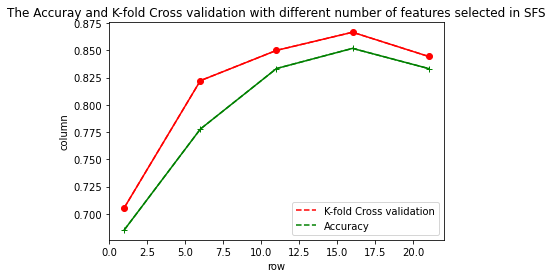

In [277]:
number_of_selected_features_SFS = []
for i in range(0,21,5):
    number_of_selected_features_SFS.append(i+1)

l1=plt.plot(number_of_selected_features_SFS,List_CV_socre_SFS,'r--',label='K-fold Cross validation')
l2=plt.plot(number_of_selected_features_SFS,List_Accuracy_SFS,'g--',label='Accuracy')
plt.plot(number_of_selected_features_SFS,List_CV_socre_SFS,'ro-',number_of_selected_features_SFS,List_Accuracy_SFS,'g+-')
plt.title('The Accuray and K-fold Cross validation with different number of features selected in SFS')
plt.xlabel('number of features selected')
plt.ylabel('scores')
plt.legend()
plt.show()


In [28]:
def RFE_with_CV_parameter(number_of_CV):
    X_Reduced,List = RFE_with_CV(X,y)

    #print(X_Reduced)
    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    start = time.process_time()
    lr.fit(X_Train_LR, Y_Train_LR)
    print(time.process_time() - start)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))


    Accuracy = metrics.accuracy_score(Y_Test_LR, prediction_LR)
    print("Accuracy:",Accuracy)

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))
    

    return np.mean(scores),Accuracy

RFE_with_CV_parameter(10)

['alpha_ec_5', 'alpha_ec_33', 'alpha_ec_45', 'beta_ec_11', 'beta_ec_12', 'theta_ec_25', 'theta_ec_46', 'alpha_eo_1', 'alpha_eo_3', 'alpha_eo_7', 'alpha_eo_9', 'alpha_eo_24', 'alpha_eo_34', 'beta_eo_26', 'beta_eo_27', 'theta_eo_6', 'theta_eo_8', 'theta_eo_19', 'theta_eo_26', 'theta_eo_27', 'ratio_beta_15', 'ratio_beta_24']
0.015625
[[31  0]
 [ 3 20]]
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        31
         1.0       1.00      0.87      0.93        23

    accuracy                           0.94        54
   macro avg       0.96      0.93      0.94        54
weighted avg       0.95      0.94      0.94        54

Accuracy: 0.9444444444444444
CV accuracy scores: [0.94444444 0.94444444 0.94444444 0.94444444 1.         0.94444444
 0.94444444 0.88888889 1.         1.        ]
CV accuracy: 0.956 +/- 0.033
number of features: (180, 22)


(0.9555555555555555, 0.9444444444444444)

In [29]:
import seaborn as sns

X_graph,List_graph = RFE_with_CV(X,y)


['alpha_ec_5', 'alpha_ec_33', 'alpha_ec_45', 'beta_ec_11', 'beta_ec_12', 'theta_ec_25', 'theta_ec_46', 'alpha_eo_1', 'alpha_eo_3', 'alpha_eo_7', 'alpha_eo_9', 'alpha_eo_24', 'alpha_eo_34', 'beta_eo_26', 'beta_eo_27', 'theta_eo_6', 'theta_eo_8', 'theta_eo_19', 'theta_eo_26', 'theta_eo_27', 'ratio_beta_15', 'ratio_beta_24']


<AxesSubplot:>

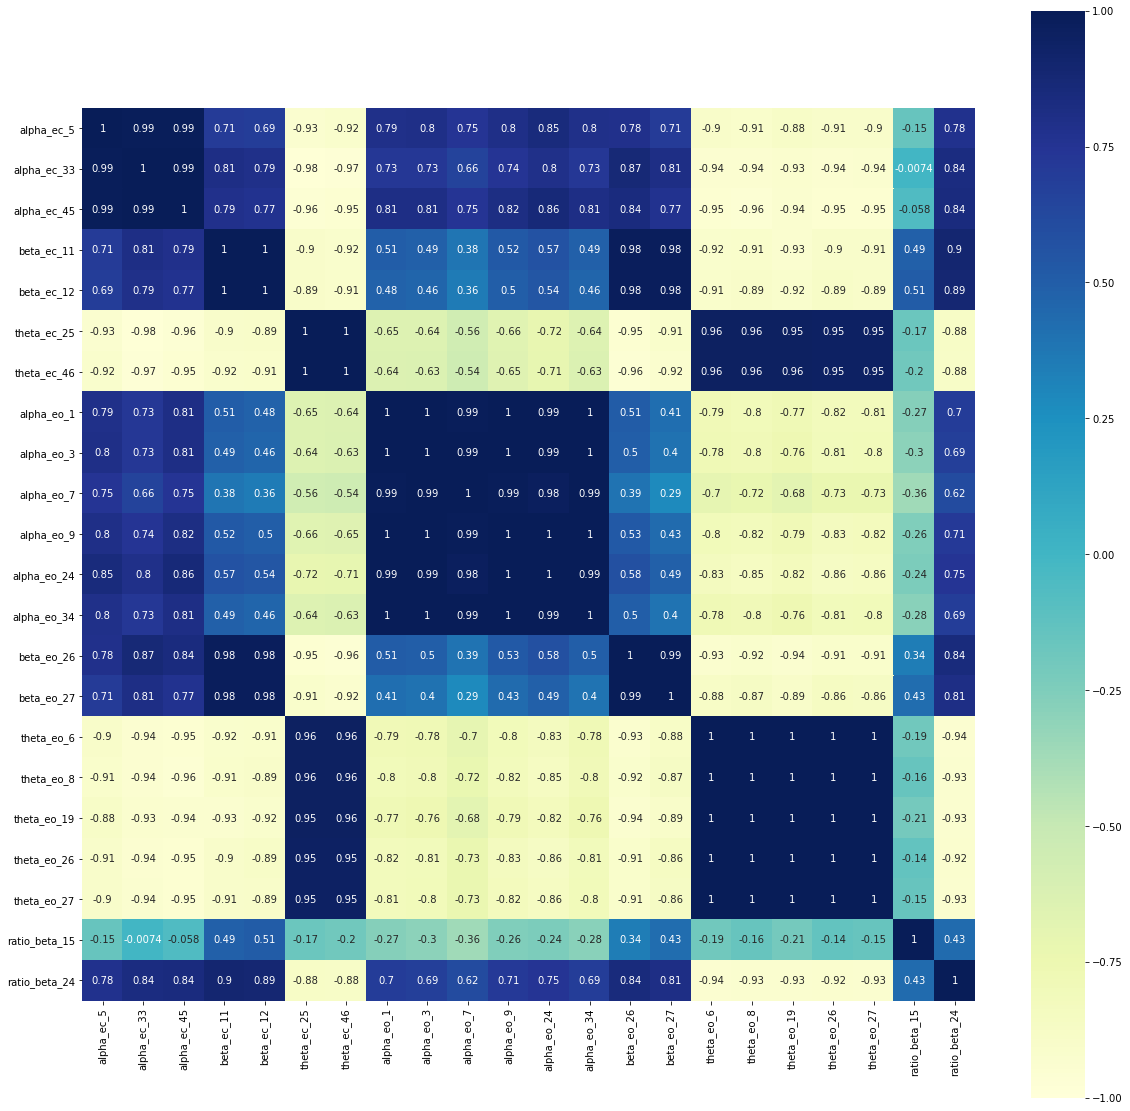

In [33]:
fig, ax = plt.subplots(figsize = (20,20))
X_graph = np.corrcoef(X_graph,rowvar=0)

sns.heatmap(pd.DataFrame(X_graph, columns = List_graph, index = List_graph), annot=True, vmax=1,vmin = -1, xticklabels= True, yticklabels= True, square=True, cmap="YlGnBu")


In [281]:
def RFE_without_parameter(number,number_of_CV):
    X_Reduced = RFE_without(X,y,number)

    #print(X_Reduced)
    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    start = time.process_time()
    lr.fit(X_Train_LR, Y_Train_LR)
    print(time.process_time() - start)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    Accuracy = metrics.accuracy_score(Y_Test_LR, prediction_LR)
    print("Accuracy:",Accuracy)

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores),Accuracy

best = 0
index = -1
List_CV_socre_RFE_without = []
List_Accuracy_RFE_without = []
for i in range(0,21,5):
    temp,temp1 = RFE_without_parameter(i+1,10)
    List_CV_socre_RFE_without.append(temp)
    List_Accuracy_RFE_without.append(temp1)
    if temp > best:
        best = temp
        index = i+1
clear_output()
RFE_without_parameter(index,10)

['alpha_ec_5', 'alpha_ec_33', 'alpha_ec_45', 'beta_ec_11', 'beta_ec_12', 'theta_ec_25', 'alpha_eo_1', 'alpha_eo_3', 'alpha_eo_7', 'alpha_eo_9', 'alpha_eo_24', 'alpha_eo_34', 'beta_eo_26', 'beta_eo_27', 'theta_eo_6', 'theta_eo_8', 'theta_eo_19', 'theta_eo_26', 'theta_eo_27', 'ratio_beta_15', 'ratio_beta_24']
0.0
[[31  0]
 [ 3 20]]
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        31
         1.0       1.00      0.87      0.93        23

    accuracy                           0.94        54
   macro avg       0.96      0.93      0.94        54
weighted avg       0.95      0.94      0.94        54

Accuracy: 0.9444444444444444
CV accuracy scores: [0.88888889 0.94444444 0.94444444 0.88888889 1.         0.94444444
 1.         0.88888889 1.         0.94444444]
CV accuracy: 0.944 +/- 0.043
number of features: (180, 21)


(0.9444444444444444, 0.9444444444444444)

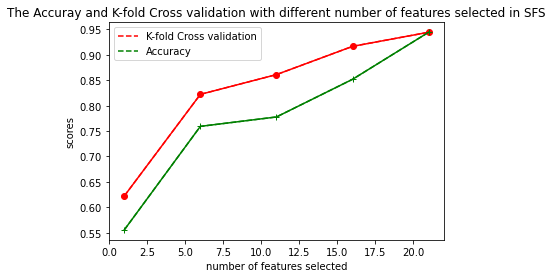

In [282]:
number_of_selected_features_RFE_without = []
for i in range(0,21,5):
    number_of_selected_features_RFE_without.append(i+1)

l1=plt.plot(number_of_selected_features_RFE_without,List_CV_socre_RFE_without,'r--',label='K-fold Cross validation')
l2=plt.plot(number_of_selected_features_RFE_without,List_Accuracy_RFE_without,'g--',label='Accuracy')
plt.plot(number_of_selected_features_RFE_without,List_CV_socre_RFE_without,'ro-',number_of_selected_features_RFE_without,List_Accuracy_RFE_without,'g+-')
plt.title('The Accuray and K-fold Cross validation with different number of features selected in SFS')
plt.xlabel('number of features selected')
plt.ylabel('scores')
plt.legend()
plt.show()

## 3.2
### Feature selection test
#### emdebbing method

In [239]:
def embedded_with_model_tree_parameter(number_of_CV):
    X_Reduced = embedded_with_model_tree(X,y)

    #print(X_Reduced)
    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    start = time.process_time()
    lr.fit(X_Train_LR, Y_Train_LR)
    print(time.process_time() - start)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    print("Accuracy:",metrics.accuracy_score(Y_Test_LR, prediction_LR))

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))
    return np.mean(scores)

embedded_with_model_tree_parameter(10)

['alpha_ec_5', 'alpha_ec_16', 'alpha_ec_17', 'alpha_ec_25', 'alpha_ec_34', 'beta_ec_5', 'beta_ec_31', 'theta_ec_0', 'theta_ec_14', 'theta_ec_22', 'theta_ec_25', 'alpha_eo_2', 'alpha_eo_3', 'alpha_eo_9', 'alpha_eo_16', 'alpha_eo_23', 'beta_eo_24', 'beta_eo_40', 'theta_eo_2', 'theta_eo_17', 'theta_eo_19', 'theta_eo_21', 'theta_eo_25', 'theta_eo_29', 'theta_eo_32', 'theta_eo_33', 'theta_eo_46', 'ratio_alpha_9', 'ratio_alpha_17', 'ratio_alpha_22', 'ratio_alpha_25', 'ratio_beta_5', 'ratio_beta_34', 'ratio_beta_35', 'ratio_beta_37', 'ratio_beta_40', 'ratio_beta_44', 'ratio_theta_3', 'ratio_theta_19', 'ratio_theta_32', 'ratio_theta_36', 'ratio_theta_40']
0.015625
[[29  2]
 [ 5 18]]
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89        31
         1.0       0.90      0.78      0.84        23

    accuracy                           0.87        54
   macro avg       0.88      0.86      0.86        54
weighted avg       0.87      0.87      0.87 

0.85

In [240]:
def embedded_with_penalty_parameter(number_of_CV):
    X_Reduced = embedded_with_penalty(X,y)

    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    start = time.process_time()
    lr.fit(X_Train_LR, Y_Train_LR)
    print(time.process_time() - start)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    print("Accuracy:",metrics.accuracy_score(Y_Test_LR, prediction_LR))

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores)

embedded_with_penalty_parameter(10)


['alpha_ec_5', 'alpha_ec_6', 'alpha_ec_11', 'alpha_ec_12', 'alpha_ec_16', 'alpha_ec_17', 'alpha_ec_23', 'alpha_ec_25', 'alpha_ec_31', 'alpha_ec_39', 'alpha_ec_45', 'beta_ec_5', 'beta_ec_6', 'beta_ec_11', 'beta_ec_12', 'theta_ec_25', 'theta_ec_32', 'theta_ec_33', 'alpha_eo_3', 'alpha_eo_9', 'alpha_eo_31', 'alpha_eo_34', 'alpha_eo_42', 'beta_eo_26', 'beta_eo_34', 'theta_eo_1', 'theta_eo_2', 'theta_eo_8', 'theta_eo_21', 'theta_eo_28', 'theta_eo_32', 'ratio_alpha_0', 'ratio_alpha_1', 'ratio_alpha_2', 'ratio_alpha_3', 'ratio_alpha_5', 'ratio_alpha_6', 'ratio_alpha_7', 'ratio_alpha_8', 'ratio_alpha_9', 'ratio_alpha_10', 'ratio_alpha_12', 'ratio_alpha_18', 'ratio_alpha_19', 'ratio_alpha_20', 'ratio_alpha_23', 'ratio_alpha_24', 'ratio_alpha_26', 'ratio_alpha_27', 'ratio_alpha_28', 'ratio_alpha_29', 'ratio_alpha_30', 'ratio_alpha_32', 'ratio_alpha_33', 'ratio_alpha_34', 'ratio_alpha_35', 'ratio_alpha_36', 'ratio_alpha_37', 'ratio_alpha_38', 'ratio_alpha_40', 'ratio_alpha_41', 'ratio_alpha_42', 

0.9388888888888889

## 3.3
### Feature selection test
#### filter method

In [284]:
def Mutual_Information_parameter(number,number_of_CV):
    X_Reduced = Mutual_Information(X,y,number)

    #print(X_Reduced)
    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    start = time.process_time()
    lr.fit(X_Train_LR, Y_Train_LR)
    print(time.process_time() - start)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    Accuracy = metrics.accuracy_score(Y_Test_LR, prediction_LR)
    print("Accuracy:",Accuracy)

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores),Accuracy
best = 0
index = -1
List_CV_socre_Mutual_Information = []
List_Accuracy_Mutual_Information = []
for i in range(0,19):
    temp,temp1 = Mutual_Information_parameter(i+1,10)
    List_CV_socre_Mutual_Information.append(temp)
    List_Accuracy_Mutual_Information.append(temp1)
    if temp > best:
        best = temp
        index = i+1
clear_output()
data = Mutual_Information_parameter(index,10)

['beta_ec_5', 'beta_ec_46', 'theta_ec_32', 'alpha_eo_9', 'alpha_eo_24', 'beta_eo_18', 'beta_eo_29', 'ratio_alpha_2', 'ratio_alpha_35', 'ratio_beta_5', 'ratio_beta_6', 'ratio_beta_8', 'ratio_beta_21', 'ratio_beta_35', 'ratio_beta_37']
0.015625
[[26  5]
 [ 4 19]]
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85        31
         1.0       0.79      0.83      0.81        23

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54

Accuracy: 0.8333333333333334
CV accuracy scores: [1.         0.77777778 0.88888889 0.88888889 0.88888889 0.94444444
 0.72222222 0.83333333 0.94444444 0.83333333]
CV accuracy: 0.872 +/- 0.079
number of features: (180, 15)


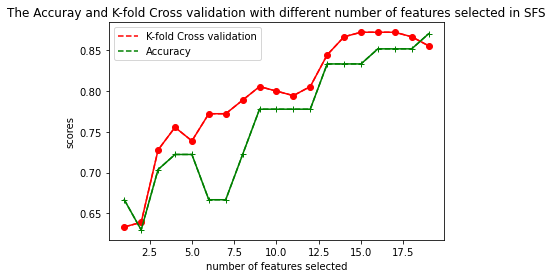

In [289]:
number_of_selected_features_Mutual_Information = []
for i in range(0,19):
    number_of_selected_features_Mutual_Information.append(i+1)

l1=plt.plot(number_of_selected_features_Mutual_Information,List_CV_socre_Mutual_Information,'r--',label='K-fold Cross validation')
l2=plt.plot(number_of_selected_features_Mutual_Information,List_Accuracy_Mutual_Information,'g--',label='Accuracy')
plt.plot(number_of_selected_features_Mutual_Information,List_CV_socre_Mutual_Information,'ro-',number_of_selected_features_Mutual_Information,List_Accuracy_Mutual_Information,'g+-')
plt.title('The Accuray and K-fold Cross validation with different number of features selected in SFS')
plt.xlabel('number of features selected')
plt.ylabel('scores')
plt.legend()
plt.show()

In [291]:
def Chi_parameter(number,number_of_CV):
    X_Reduced = Chi_Square(X,y,number)

    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    start = time.process_time()
    lr.fit(X_Train_LR, Y_Train_LR)
    print(time.process_time() - start)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    Accuracy = metrics.accuracy_score(Y_Test_LR, prediction_LR)
    print("Accuracy:",Accuracy)

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    #print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores),Accuracy
best = 0
index = -1
List_CV_socre_Chi = []
List_Accuracy_Chi = []
for i in range(0,19):
    temp,temp1 = Chi_parameter(i+1,10)
    List_CV_socre_Chi.append(temp)
    List_Accuracy_Chi.append(temp1)
    if temp > best:
        best = temp
        index = i+1
clear_output()
data = Chi_parameter(index,10)

['ratio_alpha_0', 'ratio_alpha_3', 'ratio_alpha_5', 'ratio_alpha_6', 'ratio_alpha_17', 'ratio_alpha_21', 'ratio_alpha_25', 'ratio_alpha_26', 'ratio_alpha_33', 'ratio_alpha_34', 'ratio_alpha_35', 'ratio_alpha_36', 'ratio_alpha_37', 'ratio_alpha_41', 'ratio_alpha_47', 'ratio_beta_5']
0.015625
[[23  8]
 [ 8 15]]
              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74        31
         1.0       0.65      0.65      0.65        23

    accuracy                           0.70        54
   macro avg       0.70      0.70      0.70        54
weighted avg       0.70      0.70      0.70        54

Accuracy: 0.7037037037037037
CV accuracy: 0.767 +/- 0.060
number of features: (180, 16)


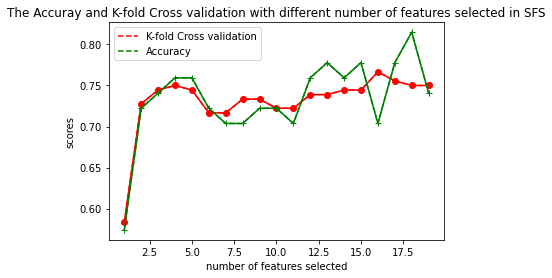

In [292]:
number_of_selected_features_Chi = []
for i in range(0,19):
    number_of_selected_features_Chi.append(i+1)

l1=plt.plot(number_of_selected_features_Chi,List_CV_socre_Chi,'r--',label='K-fold Cross validation')
l2=plt.plot(number_of_selected_features_Chi,List_Accuracy_Chi,'g--',label='Accuracy')
plt.plot(number_of_selected_features_Chi,List_CV_socre_Chi,'ro-',number_of_selected_features_Chi,List_Accuracy_Chi,'g+-')
plt.title('The Accuray and K-fold Cross validation with different number of features selected in SFS')
plt.xlabel('number of features selected')
plt.ylabel('scores')
plt.legend()
plt.show()

In [294]:
def pearson_parameter(number,number_of_CV):
    X_Reduced = pearson_correlation(X,y,number)

    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    lr.fit(X_Train_LR, Y_Train_LR)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    Accuracy = metrics.accuracy_score(Y_Test_LR, prediction_LR)
    print("Accuracy:",Accuracy)

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    #print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores),Accuracy
best = 0
index = -1
List_CV_socre_pearson = []
List_Accuracy_pearson = []
for i in range(0,19):
    temp,temp1 = pearson_parameter(i+1,10)
    List_CV_socre_pearson.append(temp)
    List_Accuracy_pearson.append(temp1)
    if temp > best:
        best = temp
        index = i+1
clear_output()
data = pearson_parameter(index,10)


Lower noise： (0.7182483686213833, 7.324017313001002e-49)
Higher noise： (0.057964292079338064, 0.3170099388532581)
['ratio_beta_0', 'ratio_beta_2', 'ratio_beta_4', 'ratio_beta_6', 'ratio_beta_7', 'ratio_beta_21', 'ratio_beta_26', 'ratio_beta_29', 'ratio_beta_34', 'ratio_beta_35', 'ratio_beta_36', 'ratio_beta_37', 'ratio_beta_38', 'ratio_beta_47']
[[20 11]
 [ 7 16]]
              precision    recall  f1-score   support

         0.0       0.74      0.65      0.69        31
         1.0       0.59      0.70      0.64        23

    accuracy                           0.67        54
   macro avg       0.67      0.67      0.66        54
weighted avg       0.68      0.67      0.67        54

Accuracy: 0.6666666666666666
CV accuracy: 0.750 +/- 0.071
number of features: (180, 14)


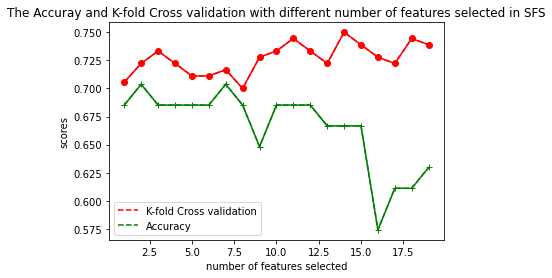

In [295]:
number_of_selected_features_pearson = []
for i in range(0,19):
    number_of_selected_features_pearson.append(i+1)

l1=plt.plot(number_of_selected_features_pearson,List_CV_socre_pearson,'r--',label='K-fold Cross validation')
l2=plt.plot(number_of_selected_features_pearson,List_Accuracy_pearson,'g--',label='Accuracy')
plt.plot(number_of_selected_features_pearson,List_CV_socre_pearson,'ro-',number_of_selected_features_pearson,List_Accuracy_pearson,'g+-')
plt.title('The Accuray and K-fold Cross validation with different number of features selected in SFS')
plt.xlabel('number of features selected')
plt.ylabel('scores')
plt.legend()
plt.show()


## 4.1
### Feature Extraction
#### PCA

In [244]:
from sklearn.decomposition import PCA
def PCA(X,number_of_k):
    pca = decomposition.PCA(n_components=number_of_k)
    data = pd.DataFrame(pca.fit_transform(X))
    return data

PCA(X,20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-6.324433,-0.508149,-2.345828,-1.599487,-0.549853,-0.056215,1.631146,2.574039,-0.371979,0.496288,0.493512,-1.621220,-0.422280,0.071515,1.483704,0.479224,-0.514896,0.349112,-0.531773,-0.045143
1,13.397174,-11.727095,0.790076,-2.125493,5.241123,4.411353,0.948103,0.689430,0.789480,-2.404141,0.643551,-0.640985,1.323684,-0.943093,0.059026,-0.435141,1.139948,1.785406,-1.637235,0.152304
2,-7.316302,0.771295,-4.085094,1.242225,0.523559,-0.071972,1.270681,-0.806582,-1.759018,-1.188229,-0.871423,-0.847530,1.274238,-0.305207,0.305883,-0.450314,0.227768,0.185436,0.246246,0.025303
3,13.626318,-7.152727,-0.793812,-3.417571,-2.289429,-5.382605,-3.855214,-2.057516,-1.021788,-0.066831,-0.031478,1.599908,-0.366139,-0.503566,-0.967919,-0.120190,-2.197926,1.110673,-1.896298,0.135463
4,-10.790449,3.919477,5.374292,1.027854,-0.913348,-0.282213,-0.281147,-1.328179,0.631558,0.240841,-0.321140,-0.399283,-0.240142,-0.702216,-1.111263,0.676334,-0.252943,-0.428314,-1.207279,0.179606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-10.837658,3.645447,2.288019,-0.784216,2.472436,-0.169664,-0.947671,3.844470,1.536800,0.545867,-0.888168,-0.574783,-1.512964,-1.110162,-1.663626,0.050483,0.686128,-0.156491,-0.611021,0.796486
176,-7.875985,1.375429,-3.027102,0.823721,-0.381037,0.531603,1.124264,0.847040,-1.350333,-0.191405,0.222849,0.593961,1.088806,0.760486,0.193589,-0.535830,0.103411,-0.364975,0.255682,-0.406129
177,-13.825137,3.699231,-1.967712,-0.254790,1.072684,0.159243,0.383334,-0.827007,0.113829,-0.440617,-0.257665,-0.216985,0.310868,0.424348,-0.139329,0.466054,-0.307424,-0.106719,0.251257,-0.850656
178,-4.586237,-0.053234,-1.045712,0.390959,3.033490,0.716511,-1.177595,-0.882447,-1.249328,-0.324411,-1.041965,0.976952,-0.355451,1.595582,1.110371,-1.523640,1.666153,-0.211624,1.775011,0.342432


## 4.2
### Feature Extraction
#### LDA

In [254]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def LDA(X,number_of_k):
    lda = LinearDiscriminantAnalysis(n_components=number_of_k)
    data = pd.DataFrame(lda.fit_transform(X,y))
    return data
LDA(X,1)

,0
0,-0.993598
1,-2.467193
2,-1.340957
3,-3.286651
4,-0.747124
...,...
175,3.242260
176,2.663744
177,3.111460
178,5.002925


## 5.1
### Feature Extraction test
#### PCA

In [298]:
def PCA_parameter(number,number_of_CV):
    X_Reduced = PCA(X,number)

    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    lr.fit(X_Train_LR, Y_Train_LR)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    Accuracy = metrics.accuracy_score(Y_Test_LR, prediction_LR)
    print("Accuracy:",Accuracy)

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    #print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores),Accuracy
best = 0
index = -1
List_CV_socre_PCA = []
List_Accuracy_PCA = []
for i in range(0,19):
    temp,temp1 = PCA_parameter(i+1,10)
    List_CV_socre_PCA.append(temp)
    List_Accuracy_PCA.append(temp1)
    if temp > best:
        best = temp
        index = i+1
clear_output()
data = PCA_parameter(index,10)

[[25  6]
 [ 6 17]]
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        31
         1.0       0.74      0.74      0.74        23

    accuracy                           0.78        54
   macro avg       0.77      0.77      0.77        54
weighted avg       0.78      0.78      0.78        54

Accuracy: 0.7777777777777778
CV accuracy: 0.756 +/- 0.075
number of features: (180, 8)


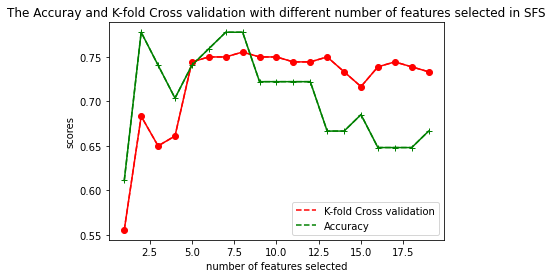

In [299]:
number_of_selected_features_PCA = []
for i in range(0,19):
    number_of_selected_features_PCA.append(i+1)

l1=plt.plot(number_of_selected_features_PCA,List_CV_socre_PCA,'r--',label='K-fold Cross validation')
l2=plt.plot(number_of_selected_features_PCA,List_Accuracy_PCA,'g--',label='Accuracy')
plt.plot(number_of_selected_features_PCA,List_CV_socre_PCA,'ro-',number_of_selected_features_PCA,List_Accuracy_PCA,'g+-')
plt.title('The Accuray and K-fold Cross validation with different number of features selected in SFS')
plt.xlabel('number of features selected')
plt.ylabel('scores')
plt.legend()
plt.show()

## 5.2
### Feature Extraction test
#### LDA

In [247]:
def LDA_parameter(number,number_of_CV):
    X_Reduced = LDA(X,number)
    print(X_Reduced)
    X_Reduced = StandardScaler().fit_transform(X_Reduced)
    X_Train_LR, X_Test_LR, Y_Train_LR, Y_Test_LR = train_test_split(X_Reduced, y, test_size = 0.30,  random_state = 101)

    lr.fit(X_Train_LR, Y_Train_LR)
    prediction_LR = lr.predict(X_Test_LR)

    print(confusion_matrix(Y_Test_LR,prediction_LR))
    print(classification_report(Y_Test_LR,prediction_LR))

    print("Accuracy:",metrics.accuracy_score(Y_Test_LR, prediction_LR))

    scores = cross_val_score(lr, X_Reduced, y, cv=number_of_CV, n_jobs = 1)
    #print('CV accuracy scores: %s' %scores)
    print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
    print('number of features: %s' %str(X_Reduced.shape))

    return np.mean(scores)

data = LDA_parameter(1,10)

            0
0   -0.993598
1   -2.467193
2   -1.340957
3   -3.286651
4   -0.747124
..        ...
175  3.242260
176  2.663744
177  3.111460
178  5.002925
179  2.445747

[180 rows x 1 columns]
[[31  0]
 [ 0 23]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       1.00      1.00      1.00        23

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54

Accuracy: 1.0
CV accuracy: 1.000 +/- 0.000
number of features: (180, 1)
